In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
 
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

2024-08-09 17:57:48.577232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 17:57:48.577418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 17:57:48.755988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

images = glob('/kaggle/input/skin-cancer-dataset/train_cancer/*/*.jpg')
print(images)
len(images)


['/kaggle/input/skin-cancer-dataset/train_cancer/benign/20.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/6.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/30.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/38.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/42.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/33.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/35.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/41.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/29.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/23.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/7.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/28.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/22.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/40.jpg', '/kaggle/input/skin-cancer-dataset/train_cancer/benign/24.jpg', '/kaggle/input/skin-cancer-dataset/train_

270

In [3]:
import pandas as pd

# Clean up file paths
images = [path.replace('\\', '/') for path in images]

# Create a DataFrame
df = pd.DataFrame({'filepath': images})

# Extract the label from the correct part of the path (benign or malignant)
df['label'] = df['filepath'].apply(lambda x: x.split('/')[-2])

# Display the first few rows
df.head()


,filepath,label
0,/kaggle/input/skin-cancer-dataset/train_cancer...,benign
1,/kaggle/input/skin-cancer-dataset/train_cancer...,benign
2,/kaggle/input/skin-cancer-dataset/train_cancer...,benign
3,/kaggle/input/skin-cancer-dataset/train_cancer...,benign
4,/kaggle/input/skin-cancer-dataset/train_cancer...,benign


# Converting the labels to 0 and 1 will save our work of label encoding so, let’s do this right now.

In [4]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,/kaggle/input/skin-cancer-dataset/train_cancer...,benign,0
1,/kaggle/input/skin-cancer-dataset/train_cancer...,benign,0
2,/kaggle/input/skin-cancer-dataset/train_cancer...,benign,0
3,/kaggle/input/skin-cancer-dataset/train_cancer...,benign,0
4,/kaggle/input/skin-cancer-dataset/train_cancer...,benign,0


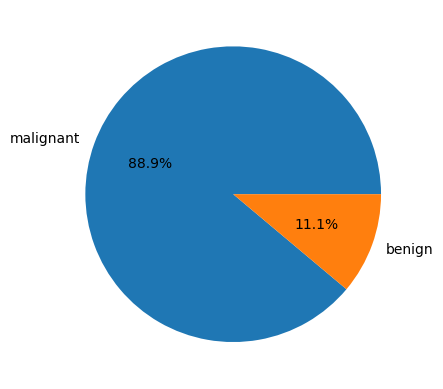

In [5]:
x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

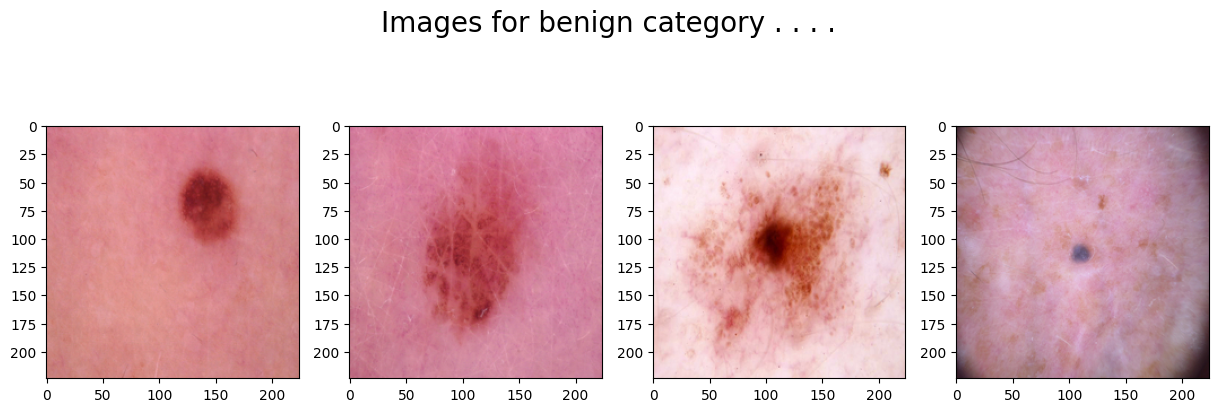

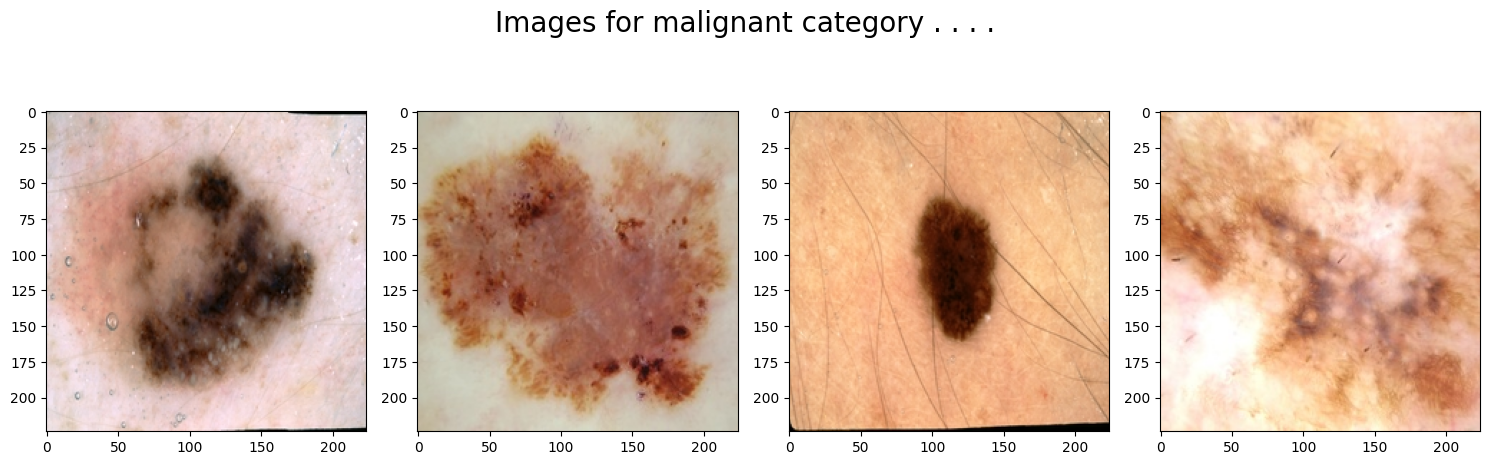

In [6]:
for cat in df['label'].unique():
    temp = df[df['label'] == cat]
 
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
 
        image_path = data[0]
 
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [7]:
features = df['filepath']
target = df['label_bin']
 
X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)
 
X_train.shape, X_val.shape

((229,), (41,))

In [8]:
label_map = {'benign': 0, 'malignant': 1}
df['label'] = df['label'].map(label_map)

In [9]:
def decode_image(filepath, label):
    # Read and decode the image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to the desired size
    
    # Normalize the image to [0, 1] range
    image = image / 255.0
    
    return image, label

In [10]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)
 
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [11]:
X_train = df['filepath'].values
Y_train = df['label'].values

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# If you have validation data, do the same for X_val and Y_val
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [12]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
 
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
from tensorflow.keras import Model
 
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
 
model = Model(inputs, outputs)

In [14]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)

In [15]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - AUC: 0.4996 - loss: 1.0140 - val_AUC: 0.7838 - val_loss: 0.8231
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - AUC: 0.4798 - loss: 0.8442 - val_AUC: 0.5135 - val_loss: 7.3996
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - AUC: 0.5663 - loss: 0.7367 - val_AUC: 0.6892 - val_loss: 5.1707
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - AUC: 0.6455 - loss: 0.6947 - val_AUC: 0.8209 - val_loss: 2.6813
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - AUC: 0.6048 - loss: 0.6523 - val_AUC: 0.9291 - val_loss: 1.2458


In [16]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.503958,0.949443,0.783784,0.823090
1,0.513958,0.773847,0.513514,7.399566
2,0.559444,0.701260,0.689189,5.170679
3,0.612292,0.645637,0.820946,2.681296
4,0.567292,0.591592,0.929054,1.245752


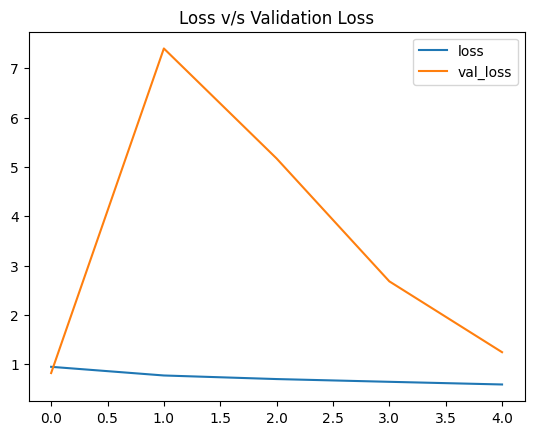

In [17]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()